<a href="https://colab.research.google.com/github/BDALab/NU20-04-00294/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook with the tutorial

## Install the libraries

In [1]:
!pip3 install --quiet numpy
!pip3 install --quiet pandas
!pip3 install --quiet matplotlib
!pip3 install --quiet xlrd
!pip3 install --quiet openpyxl
!pip3 install --quiet imbalanced-learn
!pip3 install 'scikit-learn>=0.22.0,<0.24.0' --force-reinstall
!pip3 install --quiet xgboost
!pip3 install --quiet shap
!pip3 install --quiet plot-metric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp38-cp38-manylinux1_x86_64.whl (6.8 MB)
  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scipy-1.10.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
   

## Import the libraries

In [2]:
# Ignore warnings
import warnings; warnings.simplefilter("ignore")

# Import libraries
import os
import sys
import json
import pickle
from collections import defaultdict, Counter
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import shap

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.utils import check_array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import permutation_test_score
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from plot_metric.functions import BinaryClassification

from google.colab import drive

# Set the random generator seed
seed = 42

# Matplotlib settings
plt.style.use("classic")

# Seaborn settings
sns.set()
sns.set(font_scale=1.0)
sns.set_style({"font.family":"serif", "font.serif":["Times New Roman"]})

# Show seaborn settings
sns.axes_style()

{'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': 'white',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Mount the GDrive

In [3]:
# Mount the GDrive
drive.mount("/content/gdrive")

# Prepare the paths
project_folder = os.path.join("/content", "gdrive", "My Drive", "Colab Notebooks", "AZV_tutorials")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Define the computational routines

In [4]:
# ----------------------
# Define common routines
# ----------------------

def ensure_directory(path):
    dirs = os.path.dirname(path)
    if dirs and not os.path.exists(dirs):
        os.makedirs(dirs)

def save_pickle(data, file_path):
    ensure_directory(file_path)
    with open(file_path, "wb", encoding=None) as f:
        pickle.dump(data, f)

def load_pickle(file_path):
    ensure_directory(file_path)
    with open(file_path, "rb", encoding=None) as f:
        return pickle.load(f)

def save_to_excel(df, output_path, sheet_name="Sheet1", index=False):
    ensure_directory(output_path)
    with pd.ExcelWriter(output_path) as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=index)
        writer.save()

def save_to_excel_multi(dfs, sheet_names, output_path, index=False):
    ensure_directory(output_path)
    with pd.ExcelWriter(output_path) as writer:
        for df, sheet in zip(dfs, sheet_names):
            df.to_excel(writer, sheet_name=sheet, index=index)
            writer.save()

# -----------------------------
# Define computational routines
# -----------------------------

def sensitivity_score(y_true, y_pred):
    return recall_score(y_true, y_pred)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def binarize_proba(y_prob, decision_threshold):
    return (y_prob >= decision_threshold).astype("int")

def get_fi(model, f, k=10, sort=True):
    """
    Get feature importances.
    
    This function gets the feature importances of an input <model> trained with the features 
    <f> (feature names) and a label <y> (label name). It gets the first <k> features, which 
    may or may not be sorted (according to <sort>).
    
    Parameters
    ----------
    
    model : obj
        tree-based object supporting <model>.feature_importances_ (e.g. XGBoost)
    
    f : list
        list with the feature names
    
    y : str
        str with name of the label (dependent variable: y)
    
    k : int, optional, default 10
        int value with number of important features to plot
    
    sort : bool, optional, default False
        boolean flag for plotting the sorted features
    
    Returns
    -------
    
    List of dicts with the features and their importances
    """

    # Extract the feature importances from the model
    features = list(zip(model.feature_importances_, f))

    # Get the list of sorted and trimmed feature importances
    features = sorted(features, reverse=True) if sort else features
    features = features[:k if k < len(features) else len(features)] if k else features

    # Return the feature importances
    return [
        {"feature": feature, "importance": round(float(importance), 6)} 
        for importance, feature in features
    ]

def plot_fi(
    model, 
    f, 
    y, 
    k=10, 
    sort=False, 
    ax=None, 
    fig_show=True, 
    save_as="tmp.pdf", 
    fig_kwargs=None, 
    bar_kwargs=None):
    """
    Plot feature importances.
    
    This function plots the feature importances of an input <model> trained with the features 
    <f> (feature names) and a label <y> (label name). It shows the first <k> features, which 
    may or may not be sorted (according to <sort>). If <ax> is provided, new figure and axes 
    are not created. The figure can be shown (according to <fig_show>) and stored locally 
    (according to <save_as>). Additional figure settings are privuded in <fig_kwargs>. 
    The bar-graph settings are provided in <bar_kwargs>.
    
    For more information about the used bar-graph function, see:
    https://seaborn.pydata.org/generated/seaborn.barplot.html
    
    Parameters
    ----------
    
    model : obj
        tree-based object supporting <model>.feature_importances_ (e.g. XGBoost)
    
    f : list
        list with the feature names
    
    y : str
        str with name of the label (dependent variable: y)
    
    k : int, optional, default 10
        int value with number of important features to plot
    
    sort : bool, optional, default False
        boolean flag for plotting the sorted features
    
    ax : matplotlib.axes, optional, default None
        axes object
    
    fig_show : bool, optional, default True
        boolean flag for figure showing
    
    ave_as : str, optional, default "tmp.pdf"
        str with the full-path to store the figure into
    
    fig_kwargs : dict, optional, default None
        dict with additional figure settings
    
    bar_kwargs : dict, optional, default None
        dict with additional bar-graph settings
    
    Returns
    -------
    
    Tuple with axes object and the list of dicts with the fisrt <k> features and impotances
    """
    
    # Prepare the figure settings
    fig_kwargs = fig_kwargs if fig_kwargs else {
        "fig_size": (10, 10), 
        "show_ticks": True, 
        "ticks_rotation": 90, 
        "x_label": "",
        "y_label": "",
        "title": f"feature importance: {y}"
    }
    
    # Prepare the bar-graph settings
    bar_kwargs = bar_kwargs if bar_kwargs else {"color": "#3b5b92", "edgecolor": "0.2"}
    
    # Get the feature importance(s)
    features = get_fi(model, f=f, k=k, sort=sort)
    
    # Create temporary DataFrame
    df_temp = pd.DataFrame(features)
    
    # Create figure if axes not inserted
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=fig_kwargs.get("fig_size"), sharex=False)
    
    # Create the barplot
    h = sns.barplot(x="feature", y="importance", data=df_temp, ax=ax, **bar_kwargs)
    
    # Set up the final adjustments
    h.set(xlabel=fig_kwargs.get("x_label"))
    h.set(ylabel=fig_kwargs.get("y_label"))
    h.set(title=fig_kwargs.get("title"))
    
    if fig_kwargs.get("show_ticks"):
        h.set_xticklabels(ax.get_xticklabels(), rotation=fig_kwargs.get("ticks_rotation"))
    else:
        h.set_xticklabels("")  
    
    # Save the graph
    if save_as:
        ensure_directory(save_as)
        plt.savefig(save_as, bbox_inches="tight")
    
    # Show the graph
    if fig_show:
        plt.show()
    else:
        plt.close()
    
    return ax, features

def convert_disease_status_to_integers(value, zero_class=("HC"), one_class=(), default_zero_class=("HC")):
    """
    Convert disease status to machine-understandable number representation.
    
    This function converts string-like disease status to a numerical representation that 
    is feasable for the machine learning algorithms. It gives an option of defining our 
    own sets of strings for zero and one classes (for now, it supports binary cls only).
    
    Parameters
    ----------
    
    value : str
        string-like disease status
    
    zero_class : tuple
        tuple with the strings for the zero class
    
    one_class : tuple
        tuple with the strings for the one class

    default_zero_class : tuple
        tuple with the default strings for the zero class

    Returns
    -------
    
    Integer-like class value
    """

    # Validate the input arguments
    if not isinstance(value, (str, int)):
        raise TypeError(f"Unsupported type for the value: {type(value)}")
    if not isinstance(zero_class, (list, tuple, str)):
        raise TypeError(f"Unsupported type for the zero_class: {type(zero_class)}")
    if not isinstance(one_class, (list, tuple, str)):
        raise TypeError(f"Unsupported type for the one_class: {type(one_class)}")
    if isinstance(value, int):
        return value

    # Prepare the input arguments
    zero_class = zero_class if isinstance(zero_class, (list, tuple)) else [zero_class]
    one_class = one_class if isinstance(one_class, (list, tuple)) else [one_class]

    # Convert the disease status
    if all((zero_class, one_class)):
        if value in zero_class:
            return 0
        if value in one_class:
            return 1
        raise ValueError(f"Unknown class status '{value}'")
    if not any((zero_class, one_class)):
        return 0 if value in default_zero_class else 1
    if zero_class:
        return 0 if value in zero_class else 1
    if one_class:
        return 1 if value in one_class else 0

## Load the data

In [5]:
# Prepare the paths
load_path = os.path.join(project_folder, "data")
save_path = os.path.join(project_folder, "results")
ensure_directory(load_path)
ensure_directory(save_path)

# Load the feature matrix
# Info:
# - first column = ID, it's and ID of a subject (must correspond to IDs in the clinical data)
# - other columns = features themselves
df_feat = pd.read_excel(os.path.join(load_path, "feature_matrix.xlsx"))
df_feat.set_index("ID", inplace=True)

# Load the clinical data
# Info:
# - first column = ID, it's and ID of a subject (must correspond to IDs in the features)
# - other columns = *clinical data
#
# *there is just one more columns needed = #disease -> clinical status
#  - HC = healthy control (0-class)
#  - DLB = dementia with Lewy bodies (1-class)
df_clin = pd.read_excel(os.path.join(load_path, "clinical_matrix.xlsx"))
df_clin.set_index("ID", inplace=True)

# Read me:
# later on, both tables will be merged on the ID column

In [6]:
print("\nFeature matrix")
df_feat.head(10)


Feature matrix


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,217.0,218.0,219.0,220.0,221.0,222.0,223.0,224.0,225.0,226.0
ID,,,,,,,,,,,,,,,,,,,,,
1.0,987.595686,1727.404705,1758.510002,707.178710,1373.885917,1340.948963,35.385781,81.123515,43.258018,47.512250,...,90.958415,1.163650,0.010932,4.720456,4.221082,38.160226,25.654501,2.015657,0.070530,4.790787
2.0,599.369565,1037.591814,1538.815284,453.864727,806.933422,694.374760,24.157686,44.901058,27.009731,32.370945,...,89.928862,-20.301311,6.928907,2.906137,30.359594,50.606607,22.621712,1.626164,0.150166,5.142887
3.0,1899.989090,1306.306874,1515.998007,1403.693669,1114.312882,945.151340,68.603836,63.583468,33.023775,86.535790,...,84.408405,1.347874,2.561438,4.244324,8.051629,35.280512,11.712982,2.842949,0.114149,4.585769
4.0,1164.409242,996.473500,1999.987700,774.095446,820.336255,1511.102203,48.178067,45.977790,45.542655,58.455795,...,101.145971,-13.775389,2.593585,2.383575,20.067956,45.278598,14.166002,2.326654,0.078385,5.104417
5.0,594.217121,827.217692,2072.192985,444.947439,694.718606,1641.122238,20.645761,38.719431,52.682421,25.928482,...,82.073643,-1.072215,3.740719,2.603281,14.125378,44.605158,24.333779,2.720933,0.136313,4.091297
6.0,819.004564,942.217913,2026.107592,650.758072,793.786537,1812.971142,36.603995,43.594439,53.475219,43.750709,...,92.415818,-0.653375,2.243344,3.008052,9.567441,40.044402,12.345259,2.473173,0.089997,6.584406
7.0,2286.739802,2320.510181,2574.399758,1801.481887,1981.578159,1761.417247,92.175904,108.410199,54.006124,112.037449,...,92.597994,-3.847784,2.487510,7.424637,13.761497,32.188569,14.202195,2.032495,0.088636,5.651692
8.0,1343.365750,1733.293455,2069.368754,913.193482,1356.369157,1412.508868,46.801796,77.880572,47.314598,66.441517,...,85.169802,-7.109897,6.050909,4.848791,22.837803,37.460918,21.317272,2.194424,0.105101,8.486898
9.0,1369.691603,1450.154568,2482.029200,1072.266444,1190.002839,2009.615066,59.956665,66.739838,60.317049,72.686392,...,119.284806,-1.109624,12.375101,5.119645,32.427638,27.590101,10.507113,-0.086797,NaN,1.772408


In [7]:
print("\nClinical data")
df_clin.head(10)


Clinical data


,#disease
ID,
1.0,HC
2.0,HC
3.0,HC
4.0,HC
5.0,HC
6.0,HC
7.0,HC
8.0,HC
9.0,HC


## Prepare the analysis

In [8]:
# ------------------------ #
# Define the preprocessing #
# ------------------------ #

# Prepare the redundant columns (column names to be filtered out from clinical data)
redundant_columns = []

# ------------------------------ #
# Define the classifier settings #
# ------------------------------ #

model_params = {

    # General parameters
    "booster": "gbtree", 
    "silent": True, 
    "n_jobs": -1, 

    # Learning task parameters
    "objective": "binary:logistic",
    "eval_metric": "auc", 
    "seed": seed, 

    # Tree Booster parameters
    "n_estimators": 100, 
    "learning_rate": 0.20, 
    "gamma": 1.0, 
    "max_depth": 10, 
    "subsample": 1.0, 
    "colsample_bylevel": 1, 
    "colsample_bytree": 1.0, 
    "min_child_weight": 5
}

cv_settings = {
    "num_cv_repeats": 5,
    "num_cv_folds": 10,
}

# ------------------------------------------ #
# Define the hyper-parameter tuning settings #
# ------------------------------------------ #

param_grid = {
    "clf__learning_rate": [0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3], 
    "clf__gamma": [0, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5], 
    "clf__max_depth": [10, 11, 12, 13, 14, 15],  
    "clf__subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    "clf__colsample_bylevel": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    "clf__colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    "clf__min_child_weight": [0.125, 0.25, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0], 
    "clf__scale_pos_weight": [1, 2, 3, 4, 5, 6]
}

search_settings = {
    "param_distributions": param_grid, 
    "scoring": "balanced_accuracy",
    "n_jobs": -1, 
    "n_iter": 100, 
    "verbose": 1
}

## Analyze the data

1) data preparation

Class distribution (before upsampling)
Counter({1: 103, 0: 63})
Class distribution (after upsampling)
Counter({0: 103, 1: 103})

2) hyper-parameters tuning

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1870 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2688 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3618 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4668 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  8.7min finished



Best estimator:
 score = 0.7435
 model = Pipeline(steps=[('dim', MinMaxScaler()),
                ('clf',
                 XGBClassifier(colsample_bylevel=0.1, colsample_bytree=0.1,
                               eval_metric='auc', gamma=0.05,
                               learning_rate=0.15, max_depth=10,
                               min_child_weight=0.125, n_jobs=-1,
                               scale_pos_weight=3, seed=42, silent=True,
                               subsample=0.5))])

3) classifier evaluation

Important features (top 10):
 01. importance: 0.0247, feature: 180.0
 02. importance: 0.0242, feature: 143.0
 03. importance: 0.0207, feature: 157.0
 04. importance: 0.0171, feature: 39.0
 05. importance: 0.0170, feature: 172.0
 06. importance: 0.0168, feature: 61.0
 07. importance: 0.0163, feature: 62.0
 08. importance: 0.0139, feature: 203.0
 09. importance: 0.0132, feature: 7.0
 10. importance: 0.0131, feature: 160.0

Cross-validation results:
BACC=0.54, MCC=0.14, SEN

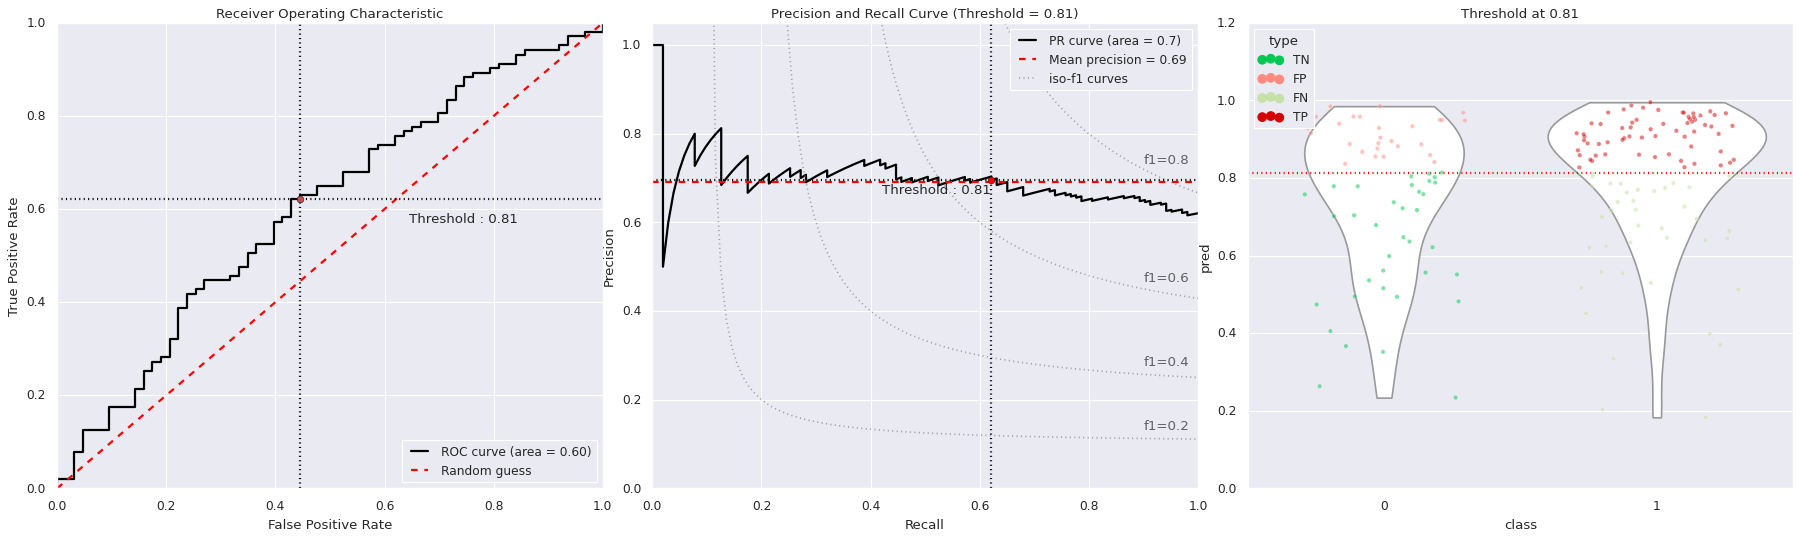

In [9]:
# -------------------- #
# [1] data preparation #
# -------------------- #

print("1) data preparation\n")

# Join the feature matrix with the clinical data
df = pd.merge(df_clin, df_feat, left_index=True, right_index=True)

# Drop the redundant columns
if redundant_columns:
    df = df.drop(columns=redundant_columns)

# Store the filtered DataFrame
save_to_excel(df,  output_path=os.path.join(save_path, f"df_original.xlsx"), index=True) 

# Keep only the features with certain percentage of non-missing values (e.g. 90% of rows)
df = df.dropna(thresh=df.shape[0] * 0.90, axis=1)

# Drop the features with zero values only
df = df.loc[:, (df != 0).any(axis=0)]

# Replace the features with the remaining missing values with median value
df = df.fillna(df.median())

# Convert the disease status into integer values
df["#disease"] = [
    convert_disease_status_to_integers(value, zero_class=("HC"), one_class=("DLB")) 
    for value in df["#disease"]
]

# Store the preprocessed DataFrame
save_to_excel(df,  output_path=os.path.join(save_path, f"df_preprocessed.xlsx"), index=True) 

# Dissassemble the data into feature matrix and clinical data
df_feat_ = df[[c for c in df.columns if c not in ("#disease", )]]
df_clin_ = df[["#disease"]]

# Prepare X, y
X = df_feat_.values
y = df_clin_["#disease"].values
y = y.reshape((len(y), ))

# Get the feature labels
feature_labels = df_feat_.columns.tolist()

# Store the feature labels
with open(os.path.join(save_path, f"feature_labels.json"), "wt") as f:
    json.dump({"feature_labels": feature_labels}, f)

# Store the original X, y distribution
np.save(os.path.join(save_path, f"X_original.npy"), X)
np.save(os.path.join(save_path, f"y_original.npy"), y)

print("Class distribution (before upsampling)")
pprint(Counter(y))

# Upsample the minority class
X_smote, y_smote = SMOTE(sampling_strategy="auto", k_neighbors=10, random_state=seed).fit_resample(X, y)

# Store the upsampled X, y distribution
np.save(os.path.join(save_path, f"X_upsampled.npy"), X_smote)
np.save(os.path.join(save_path, f"y_upsampled.npy"), y_smote)

print("Class distribution (after upsampling)")
pprint(Counter(y_smote))
print("")

# --------------------------- #
# [2] hyper-parameters tuning #
# --------------------------- #

print("2) hyper-parameters tuning\n")

# Create the processing pipeline
pipe = Pipeline([
    ("dim", MinMaxScaler(feature_range=(0, 1))), 
    ("clf", xgb.XGBClassifier(**model_params))
])

# Get the cross-validation indices
cv = RepeatedStratifiedKFold(
    n_splits=cv_settings.get("num_cv_folds"), 
    n_repeats=cv_settings.get("num_cv_repeats"), 
    random_state=seed)

# Employ the hyper-parameter tuning
random_search = RandomizedSearchCV(pipe, cv=cv, random_state=seed, **search_settings)
random_search.fit(X_smote, y_smote)

# Get the best estimator
best_estimator = random_search.best_estimator_

print("\nBest estimator:")
print(f" score = {random_search.best_score_:.4f}")
print(f" model = {random_search.best_estimator_}\n")

# Store the best estimator
save_pickle(best_estimator, os.path.join(save_path, f"trained_model.pkl"))

# Store the best hyper-parameters
with open(os.path.join(save_path, f"trained_model_hyper_parameters.json"), "wt") as f:
    json.dump({"hyper_parameters": best_estimator.get_params().get("clf").get_params()}, f)

# ------------------------- #
# [3] classifier evaluation #
# ------------------------- #

print("3) classifier evaluation\n")

# Print the feature importances
feature_importances = get_fi(model=best_estimator["clf"], f=feature_labels, k=10, sort=True)
print(f"Important features (top 10):")

for imp, item in enumerate(feature_importances, 1):
    print(f" {imp:02}. importance: {item['importance']:.04f}, feature: {item['feature']}")
print("")

# Store the feature importances
with open(os.path.join(save_path, f"feature_importances.json"), "wt") as f:
    json.dump({"feature_importances": feature_importances}, f)

# Plot the feature importances
axes, fis = plot_fi(
    best_estimator["clf"], 
    f=feature_labels, 
    y="#disease", 
    sort=True, 
    fig_show=False, 
    save_as=os.path.join(save_path, f"feature_importances.pdf"))

# Extract the samples
samples = df_feat_.index.tolist()

# Prepare the classified samples buffer
classified_samples = []

# Prepare the cross-validation
cv = LeaveOneOut()

# Cross-validate the classifier
y_true_buffer = []
y_pred_buffer = []
y_prob_buffer = []

for train_index, test_index in cv.split(X):

    # Split the data
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Get the testing sample
    sample = samples[test_index[0]]

    # Create the processing pipeline
    pipe = Pipeline([
        ("dim", best_estimator.get_params().get("dim")), 
        ("clf", xgb.XGBClassifier(**best_estimator.get_params().get("clf").get_params()))
    ])

    # Train the model on the training set
    pipe.fit(X_train, y_train)

    # Evaluate the model on the hold out set
    y_true = y_test
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    y_true_buffer += y_true.tolist()
    y_pred_buffer += y_pred.tolist()
    y_prob_buffer += y_prob.tolist()

    # Add the classified sample into the buffer
    classified_samples.append(sample)

# Compute the model's performance
y_true = np.array(y_true_buffer)
y_pred = np.array(y_pred_buffer)
y_prob = np.array(y_prob_buffer)

bacc = round(float(balanced_accuracy_score(y_true, y_pred)), 4)
mcc = round(float(matthews_corrcoef(y_true, y_pred)), 4)
sen = round(float(sensitivity_score(y_true, y_pred)), 4)
spe = round(float(specificity_score(y_true, y_pred)), 4)
pre = round(float(precision_score(y_true, y_pred)), 4)
f1 = round(float(f1_score(y_true, y_pred)), 4)

print(f"Cross-validation results:")
print(f"BACC={bacc:.2f}, MCC={mcc:.2f}, SEN={sen:.2f}, SPE={spe:.2f}, PRE={pre:.2f}, F1={f1:.2f}\n")

# Store the classification performace
results = pd.DataFrame([{"BACC": bacc, "MCC": mcc, "SEN": sen, "SPE": spe, "PRE": pre, "F1": f1}])
save_to_excel(
    results, 
    output_path=os.path.join(save_path, f"cls_results_original.xlsx"), 
    index=False)

# Evaluate the model's miss-classifications
classified_samples_info = pd.DataFrame({
    "samples": np.array(classified_samples), 
    "y_true": y_true, 
    "y_pred": y_pred,
    "y_prob": y_prob
})

# Store the error analysis
save_to_excel(
    classified_samples_info, 
    output_path=os.path.join(save_path, f"cls_results_original_error_analysis.xlsx"), 
    index=False)

# ---------------- #
# [4] ROC analysis #
# ---------------- #

print("4) ROC analysis\n")

# Fine-tune the decision threshold
thresholds = np.arange(0, 1, 0.0001)
prediction = [matthews_corrcoef(y_true, binarize_proba(y_prob, t)) for t in thresholds]

printed = list(sorted(prediction, reverse=True))
print(f"Sorted predictions for each threshold")
print(printed)
print("")

index_threshold = np.argmax(prediction)
tuned_threshold = thresholds[index_threshold]

# Predict the class labels using the fine-tuned decision threshold
y_pred = binarize_proba(y_prob, tuned_threshold)

bacc = round(float(balanced_accuracy_score(y_true, y_pred)), 4)
mcc = round(float(matthews_corrcoef(y_true, y_pred)), 4)
sen = round(float(sensitivity_score(y_true, y_pred)), 4)
spe = round(float(specificity_score(y_true, y_pred)), 4)
pre = round(float(precision_score(y_true, y_pred)), 4)
f1 = round(float(f1_score(y_true, y_pred)), 4)

print(f"Cross-validation results (decision threshold for positive class {tuned_threshold:.6f}):")
print(f"BACC={bacc:.2f}, MCC={mcc:.2f}, SEN={sen:.2f}, SPE={spe:.2f}, PRE={pre:.2f}, F1={f1:.2f}\n")

# Store the classification performace
results = pd.DataFrame([{"BACC": bacc, "MCC": mcc, "SEN": sen, "SPE": spe, "PRE": pre, "F1": f1}])
save_to_excel(
    results, 
    output_path=os.path.join(save_path, f"cls_results_tuned_({tuned_threshold:.6f}).xlsx"), 
    index=False)

# Build the model summarizer
clf_summarizer = BinaryClassification(y_true, y_prob, labels=["0", "1"], threshold=tuned_threshold)

# Print the classification report
clf_summarizer.print_report()
print("")

# Visualize the metrics
fig = plt.figure(figsize=(28, 16))
plt.subplot2grid(shape=(2, 6), loc=(0, 0), colspan=2)
clf_summarizer.plot_roc_curve()
plt.subplot2grid(shape=(2, 6), loc=(0, 2), colspan=2)
clf_summarizer.plot_precision_recall_curve()
plt.subplot2grid(shape=(2, 6), loc=(0, 4), colspan=2)
clf_summarizer.plot_class_distribution()

fig.savefig(os.path.join(save_path, f"cls_roc.pdf"), bbox_inches="tight")
plt.show()